<h1>This is_ Inception-ResNet with_ convolutionnal layer after concatenate</h1>
<h2>With in build loss function and accuracy</h2>

In [1]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Activation, concatenate, DepthwiseConv2D, Multiply,Dropout
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D,Flatten, Layer,BatchNormalization, Add,Reshape,AveragePooling2D

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



In [2]:
tf.__version__

'2.9.0'

In [3]:
input_shape = (224, 224, 3)

train_dir = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\train'
test_dir = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\test'

batch_size = 16
num_classes = 2
# filter_factor = 8

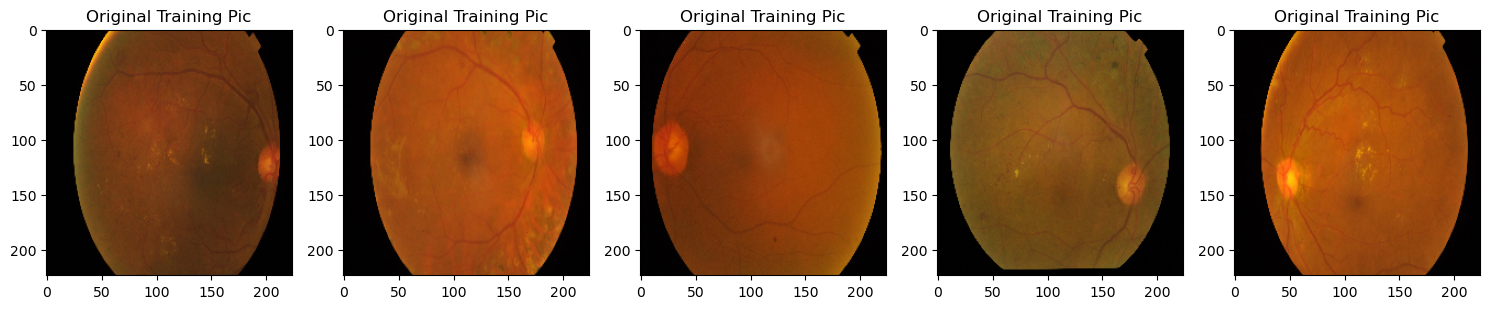

In [4]:
train_diabetic = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\train\diabetic'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)




Found 2708 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


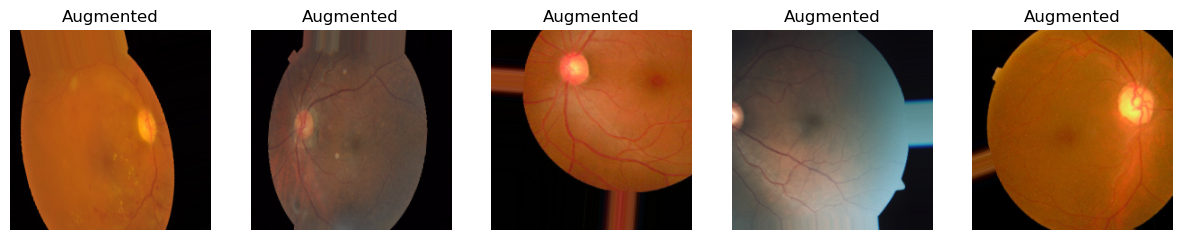

In [6]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [7]:
def attention_block_2(x):
    # 使用卷积层创建一个更复杂的注意力机制
    attention_network = Conv2D(96, (3, 3), padding='same')(x)  # 增加卷积层
    attention_network = Activation('relu')(attention_network)
    attention_network = Conv2D(1, (1, 1), padding='same')(attention_network)  # 生成注意力图
    
    attention_output = Activation('sigmoid')(attention_network)
    scaled_feature = Multiply()([x, attention_output])  # 将注意力图应用于原始特征

    return scaled_feature

def simple_model_1(input_shape):
    inputs = Input(shape = input_shape)
    #Input convolution
    x = Conv2D(64, (3, 3), activation = 'leaky_relu',
               padding = 'same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)
    
    #First Dethwise Convolution
    x = Conv2D(64, (3, 3),  
               padding = 'same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)

    
    #Second convolutional layer
    x = Conv2D(32, (3, 3), 
               padding = 'same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)
    
    
    x = GlobalAveragePooling2D()(x)
    model_1 = Model(inputs, x)
    
    return model_1

def resnet_inception_simple(input_shape):
    inputs = Input(shape=input_shape)

    # Input Convolution
    x = Conv2D(32, (7, 7), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual and Inception Blocks
    for filters in [32, 32, 64, 32]:
        # Residual Block
        x_r = Conv2D(filters, (3, 3), strides=(1, 1), padding='same', 
                     activation='relu',kernel_initializer='he_normal')(x)
        x_r = BatchNormalization()(x_r)
        x_r = Conv2D(filters, (3, 3), strides=(1, 1), padding='same', 
                     activation='relu',kernel_initializer='he_normal')(x_r)
        x_r = BatchNormalization()(x_r)

        # Inception Block
        branch_0 = Conv2D(64, (1, 1), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(x)
        branch_0 = BatchNormalization()(branch_0)

        branch_1 = Conv2D(64, (1, 1), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(x)
        branch_1 = BatchNormalization()(branch_1)
        branch_1 = Conv2D(32, (3, 3), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(branch_1)
        branch_1 = BatchNormalization()(branch_1)

        branch_2 = Conv2D(128, (1, 1), padding='same', activation='relu',
                          kernel_initializer='he_normal')(x)
        branch_2 = BatchNormalization()(branch_2)
        branch_2 = Conv2D(32, (3, 3), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(branch_2)
        branch_2 = BatchNormalization()(branch_2)
#         branch_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(branch_2)
#         branch_2 = BatchNormalization()(branch_2)

#         branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
#         branch_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(branch_3)
#         branch_3 = BatchNormalization()(branch_3)

        # Ensure concatenation along the channel axis
        x_i = concatenate([branch_0, branch_1,branch_2], axis = -1)
    
        # Make sure the number of filters after concatenation in x_i matches with x_r
        x_i = Conv2D(filters, (1, 1), padding = 'same', activation = 'relu')(x_i)
        x_i = BatchNormalization()(x_i)
        
        x_r = attention_block_2(x_r)
        x_i = attention_block_2(x_i)

        # Combine Residual and Inception Outputs
        x = Add()([x_r, x_i])
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
#     outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, x)
    
    return model



def build_ensemble_model(input_shape):
    inputs = Input(shape = input_shape)

    model_1 = simple_model_1(input_shape)
    output1 = model_1(inputs) 
    
    
    IR_output = resnet_inception_simple(input_shape)(inputs)
    
    output1_reshaped = Reshape((1, 1, -1))(output1)
    IR_output_reshaped = Reshape((1, 1, -1))(IR_output)
    
    combined_result = concatenate([output1_reshaped, IR_output_reshaped])
    combined_result = Conv2D(32, (3, 3), padding='same', 
                             activation='relu', kernel_initializer='he_normal')(combined_result)
    
    combined_result = BatchNormalization()(combined_result)
    combined_result = Dropout(0.4)(combined_result)
    combined_result = GlobalAveragePooling2D()(combined_result)
    
    # 最后的分类层
    outputs = Dense(2, activation='softmax')(combined_result)
    model = Model(inputs = inputs, outputs=outputs)
    
    return model



In [8]:
ensemble_model = build_ensemble_model(input_shape)

ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 32)           196643      ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 32)           694120      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 1, 32)     0           ['model[0][0]']            

In [9]:


from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K

lr = 0.001
Optimizer = Adam(learning_rate = lr)

ensemble_model.compile(
    optimizer=Optimizer,
    loss = 'categorical_crossentropy',
    metrics=[
        'accuracy', 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=2, average = micro)
    ]
)


In [10]:


lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=20, verbose=1, 
                               restore_best_weights=True)

In [11]:
history = ensemble_model.fit(train_generator, epochs = 120, validation_data=(validation_generator), 
                             callbacks = [lr_reduction, early_stopping])

Epoch 1/120
170/170 [==============================] - 70s 338ms/step - loss: 0.4560 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8845 - f1_score: 0.8131 - val_loss: 0.8830 - val_accuracy: 0.5074 - val_precision: 0.5074 - val_recall: 0.5074 - val_auc: 0.5719 - val_f1_score: 0.3366 - lr: 0.0010
Epoch 2/120
170/170 [==============================] - 54s 319ms/step - loss: 0.3489 - accuracy: 0.8637 - precision: 0.8637 - recall: 0.8637 - auc: 0.9301 - f1_score: 0.8637 - val_loss: 1.3366 - val_accuracy: 0.5074 - val_precision: 0.5074 - val_recall: 0.5074 - val_auc: 0.6367 - val_f1_score: 0.3366 - lr: 0.0010
Epoch 3/120
170/170 [==============================] - 54s 319ms/step - loss: 0.2760 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9533 - f1_score: 0.8977 - val_loss: 1.1662 - val_accuracy: 0.5446 - val_precision: 0.5446 - val_recall: 0.5446 - val_auc: 0.6169 - val_f1_score: 0.4717 - lr: 0.0010
Epoch 4/120
170/170 [==============================] - 

Epoch 27/120
170/170 [==============================] - 54s 315ms/step - loss: 0.1956 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9740 - f1_score: 0.9350 - val_loss: 0.1443 - val_accuracy: 0.9579 - val_precision: 0.9579 - val_recall: 0.9579 - val_auc: 0.9865 - val_f1_score: 0.9579 - lr: 0.0010
Epoch 28/120
170/170 [==============================] - 54s 315ms/step - loss: 0.1791 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9761 - f1_score: 0.9450 - val_loss: 0.1684 - val_accuracy: 0.9381 - val_precision: 0.9381 - val_recall: 0.9381 - val_auc: 0.9828 - val_f1_score: 0.9381 - lr: 0.0010
Epoch 29/120
170/170 [==============================] - 54s 316ms/step - loss: 0.1975 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9728 - f1_score: 0.9391 - val_loss: 0.1610 - val_accuracy: 0.9455 - val_precision: 0.9455 - val_recall: 0.9455 - val_auc: 0.9826 - val_f1_score: 0.9455 - lr: 0.0010
Epoch 30/120
170/170 [==============================

Epoch 53/120
170/170 [==============================] - 54s 317ms/step - loss: 0.1252 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9880 - f1_score: 0.9623 - val_loss: 0.0747 - val_accuracy: 0.9802 - val_precision: 0.9802 - val_recall: 0.9802 - val_auc: 0.9957 - val_f1_score: 0.9802 - lr: 0.0010
Epoch 54/120
170/170 [==============================] - 54s 316ms/step - loss: 0.1313 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9867 - f1_score: 0.9590 - val_loss: 0.0870 - val_accuracy: 0.9728 - val_precision: 0.9728 - val_recall: 0.9728 - val_auc: 0.9929 - val_f1_score: 0.9728 - lr: 0.0010
Epoch 55/120
170/170 [==============================] - 54s 316ms/step - loss: 0.1251 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9881 - f1_score: 0.9586 - val_loss: 0.1010 - val_accuracy: 0.9728 - val_precision: 0.9728 - val_recall: 0.9728 - val_auc: 0.9912 - val_f1_score: 0.9728 - lr: 0.0010
Epoch 56/120
170/170 [==============================

Epoch 79/120
170/170 [==============================] - 54s 314ms/step - loss: 0.1010 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9924 - f1_score: 0.9679 - val_loss: 0.0595 - val_accuracy: 0.9901 - val_precision: 0.9901 - val_recall: 0.9901 - val_auc: 0.9943 - val_f1_score: 0.9901 - lr: 1.0000e-04
Epoch 80/120
170/170 [==============================] - 54s 314ms/step - loss: 0.0986 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9926 - f1_score: 0.9712 - val_loss: 0.0650 - val_accuracy: 0.9777 - val_precision: 0.9777 - val_recall: 0.9777 - val_auc: 0.9951 - val_f1_score: 0.9777 - lr: 1.0000e-04
Epoch 81/120
170/170 [==============================] - 54s 316ms/step - loss: 0.0945 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9932 - f1_score: 0.9697 - val_loss: 0.0727 - val_accuracy: 0.9802 - val_precision: 0.9802 - val_recall: 0.9802 - val_auc: 0.9938 - val_f1_score: 0.9802 - lr: 1.0000e-04
Epoch 82/120
170/170 [==================

Epoch 105/120
170/170 [==============================] - 54s 315ms/step - loss: 0.0907 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9930 - f1_score: 0.9738 - val_loss: 0.0631 - val_accuracy: 0.9802 - val_precision: 0.9802 - val_recall: 0.9802 - val_auc: 0.9947 - val_f1_score: 0.9802 - lr: 1.0000e-05
Epoch 106/120
170/170 [==============================] - 54s 316ms/step - loss: 0.0876 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9926 - f1_score: 0.9738 - val_loss: 0.0576 - val_accuracy: 0.9876 - val_precision: 0.9876 - val_recall: 0.9876 - val_auc: 0.9955 - val_f1_score: 0.9876 - lr: 1.0000e-05
Epoch 107/120
170/170 [==============================] - 54s 317ms/step - loss: 0.0791 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9950 - f1_score: 0.9756 - val_loss: 0.0622 - val_accuracy: 0.9851 - val_precision: 0.9851 - val_recall: 0.9851 - val_auc: 0.9955 - val_f1_score: 0.9851 - lr: 1.0000e-05
Epoch 108/120
170/170 [==============

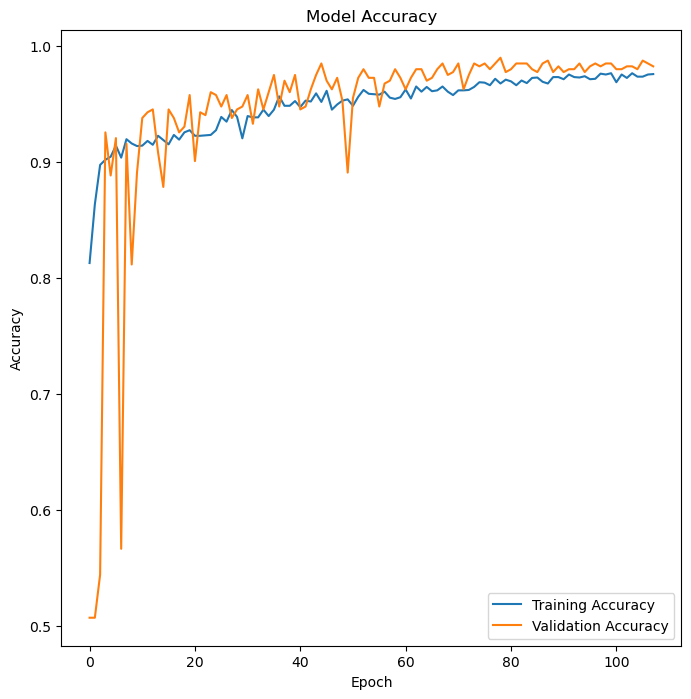

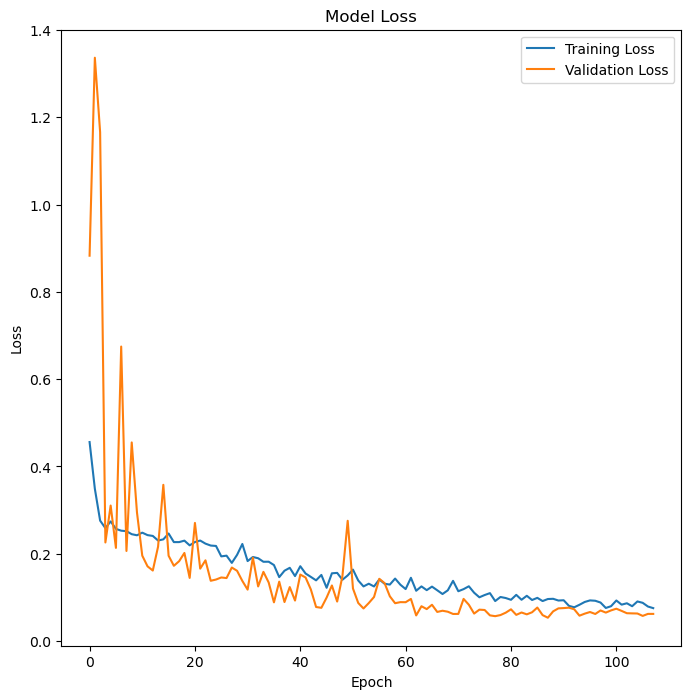

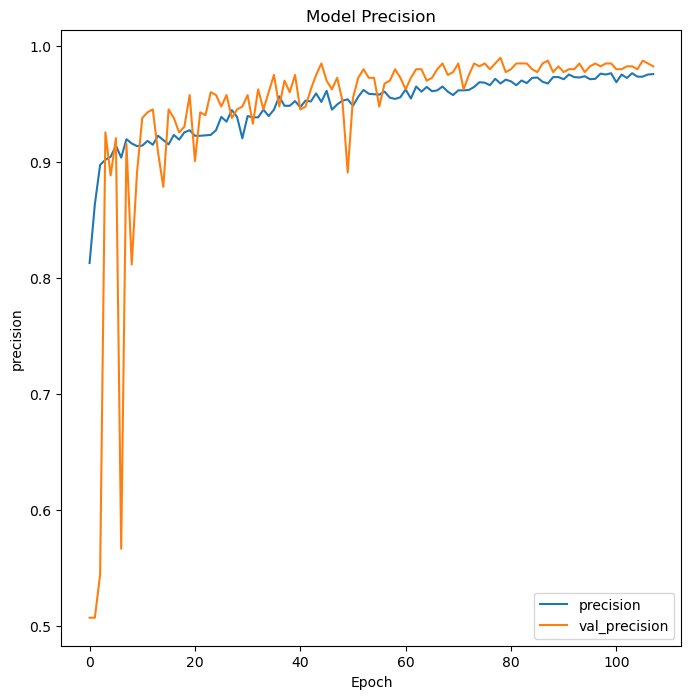

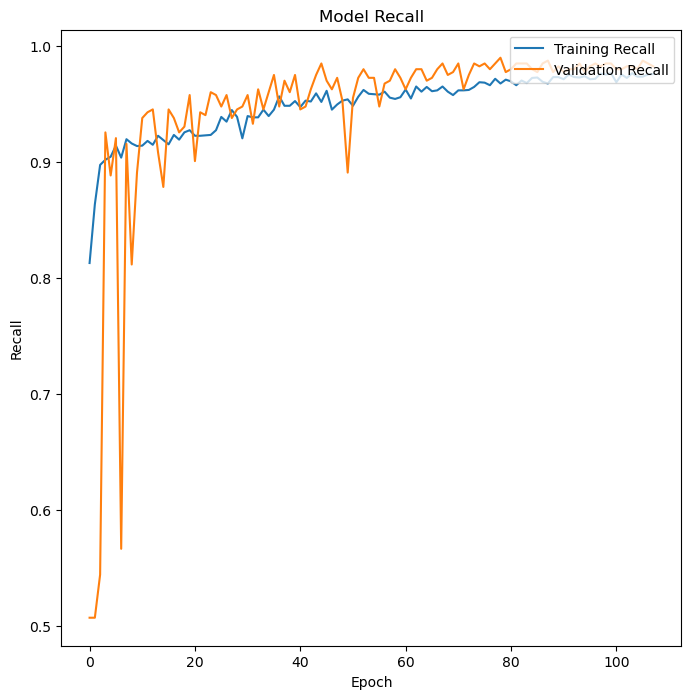

In [34]:
plt.figure(figsize = (8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()


plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(['precision', 'val_precision'], loc = 'lower right')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'],loc='lower right')
plt.show()




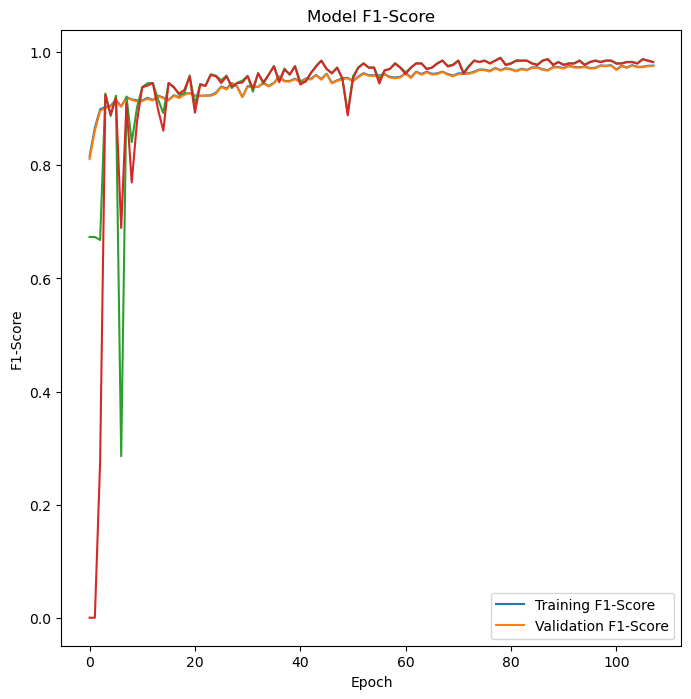

In [64]:
plt.close('all')

plt.figure(figsize =(8, 8))
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc= 'lower right')
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# 计算F1-Score
f1 = f1_score(collected_true_labels, ensemble_predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(collected_true_labels, ensemble_predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


17/17 [==============================] - 2s 142ms/step


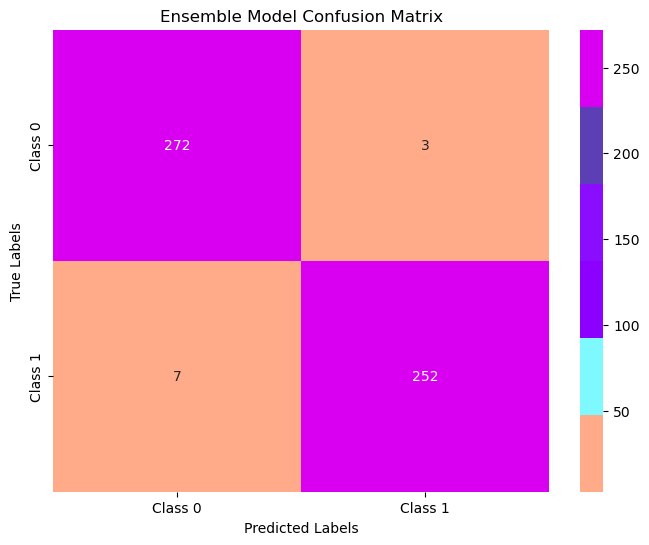

In [55]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize lists to collect images and true labels
collected_images = []
collected_true_labels = []

# Use a traditional for loop to collect images and labels
for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    collected_images.append(images)
    collected_true_labels.append(true_labels)

# Concatenate the lists of images and labels
collected_images = np.concatenate(collected_images)
collected_true_labels = np.argmax(np.concatenate(collected_true_labels), axis=1)

# Make predictions and get predicted labels
ensemble_predictions = ensemble_model.predict(collected_images)
ensemble_predicted_labels = np.argmax(ensemble_predictions, axis=1)

# Generate and plot confusion matrix
ensemble_conf_matrix = confusion_matrix(collected_true_labels, ensemble_predicted_labels)
plt.figure(figsize=(8, 6))

#customizae color
amethyst_palette = sns.color_palette([
    "#FFAA88",  
    "#7DF9FF",  
    "#8B00FF",  
    "#8A0DFF",  
    "#5D3FB5",  
    "#D900F1"   
])
sns.heatmap(ensemble_conf_matrix, 
            annot=True, 
            fmt="d", 
            cmap=amethyst_palette, 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])

plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


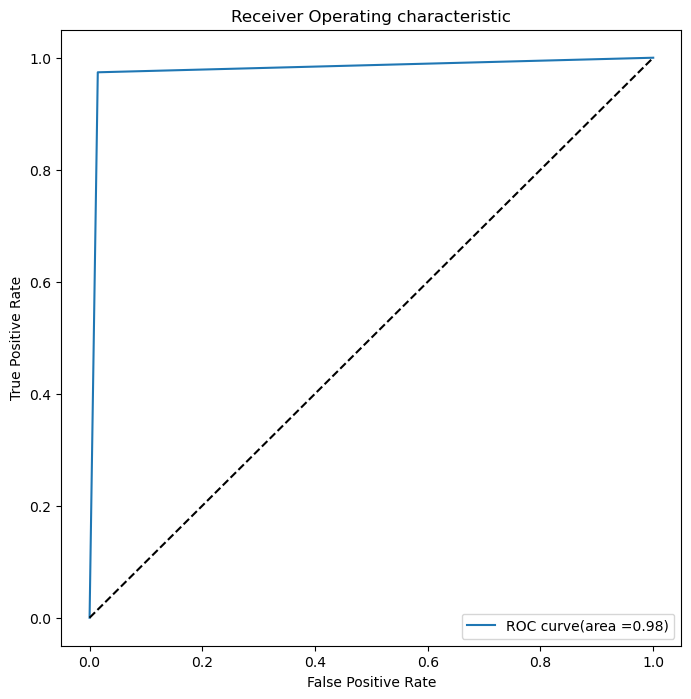

In [16]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(collected_true_labels, ensemble_predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [17]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)



sensitivity: 0.9739776951672863
specificity: 0.9854545454545455


17/17 [==============================] - 2s 144ms/step


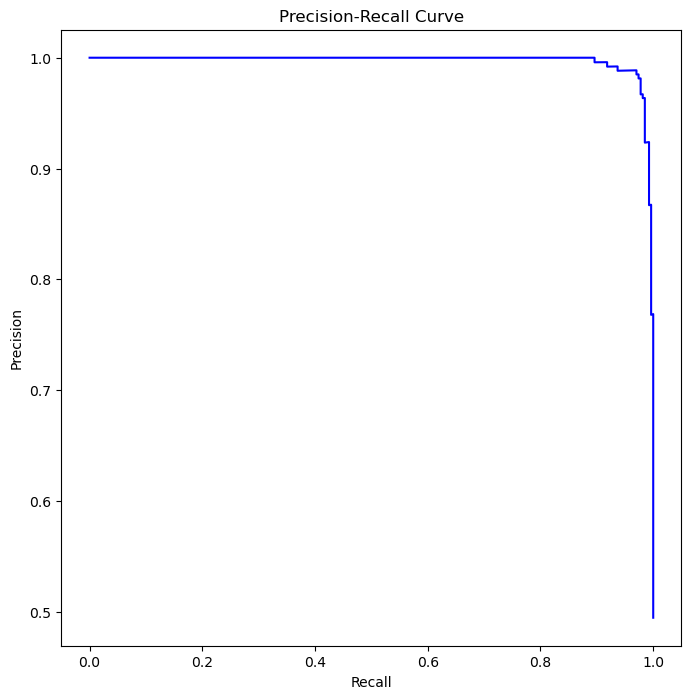

In [21]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs = ensemble_model.predict(collected_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(collected_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [40]:
# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = ensemble_model.predict(collected_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(collected_true_labels, y_pred_labels)
print(report)


17/17 [==============================] - 2s 143ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       272
           1       0.98      0.97      0.97       262

    accuracy                           0.98       534
   macro avg       0.98      0.98      0.98       534
weighted avg       0.98      0.98      0.98       534



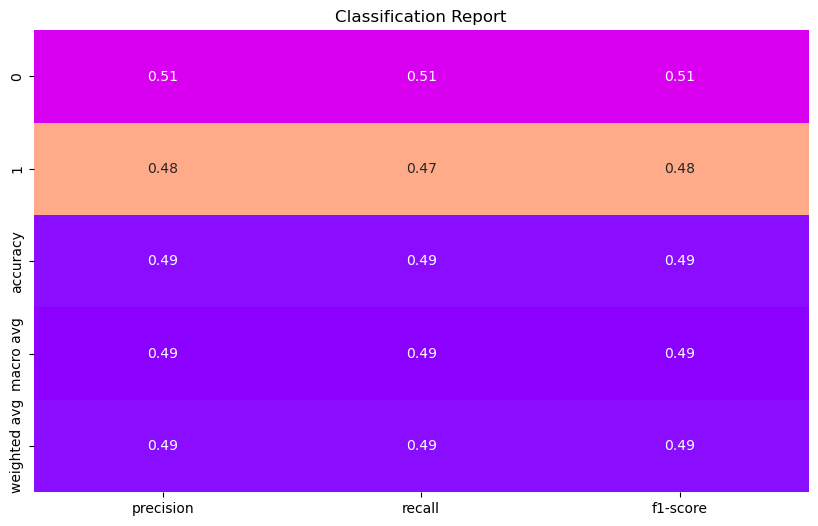

In [56]:
import pandas as pd
from sklearn.metrics import classification_report


# 生成分类报告
report = classification_report(collected_true_labels, y_pred_labels, output_dict=True)

# 转换为 DataFrame
report_df = pd.DataFrame(report).transpose()

# 删除支持列，因为它不适合于热力图
report_df = report_df.drop(columns=['support'])

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap=amethyst_palette, cbar=False)
plt.title("Classification Report")
plt.show()


In [66]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

35/35 [==============================] - 3s 81ms/step - loss: 0.0701 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9800
Test loss: 0.07010985910892487
Test accuracy: 0.9800000190734863
Test precision: 0.9800000190734863
Test recall: 0.9800000190734863
Test AUC: 0.9966347217559814
Test F1 Score: [0.98039216 0.97959185]


In [68]:
import numpy as np
import matplotlib.pyplot as plt

def generate_grad(model, img_array, target_layer, output_layer):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(target_layer).output, model.get_layer(output_layer).output]
    )

    with tf.GradientTape() as tape:
        conv_output, model_output = grad_model(img_array)
        loss = model_output[:, 0]  
    grads = tape.gradient(loss, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)

    # 添加一个小的常数避免分母为零
    heatmap /= (np.max(heatmap) + 1e-10)
    return heatmap

output_layer_name1 = ensemble_model.output.name.split("/")[0]

num_images = 5

for i in range(num_images):
    batch = next(test_generator)

    img_array = batch[0]
    label = batch[1]

    heatmap1 = generate_grad(ensemble_model, img_array, 'conv2d_58', output_layer_name1)

#     target_size = max(heatmap1.shape[0], heatmap2.shape[0]), max(heatmap1.shape[1], heatmap2.shape[1])
    target_size = heatmap1.shape[0], heatmap1.shape[1]  
    heatmap1_resized = tf.image.resize(heatmap1[..., np.newaxis], target_size)[..., 0]
    heatmap = heatmap1_resized

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224))[..., 0]
    heatmap_weighted = heatmap_resized * 1

    weighted_img = heatmap_weighted[..., np.newaxis] * img_array[0]
    weighted_img /= np.max(weighted_img) 

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title(f'Original Image (Label: {label[0]})')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(weighted_img[..., 0],cmap='jet')
    plt.title('Grad-CAM Image')
    plt.axis('off')

    plt.show()


ResourceExhaustedError: Exception encountered when calling layer "conv2d" (type Conv2D).

OOM when allocating tensor with shape[16,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv2d" (type Conv2D):
  • inputs=tf.Tensor(shape=(16, 224, 224, 3), dtype=float32)

#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model


from numba import cuda

cuda.select_device(0)
cuda.close()